In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc
# import scvelo as scv

# read the full dataset
# data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_GSE128639/Stuart_bm_v2.h5ad')
data.shape

(30011, 17009)

In [4]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
# %% Merge L2 cell types
def merge_L2(adata):
    # Create a new column 'celltype.l2.merge' that is a copy of 'celltype.l2'
    adata.obs['celltype.l2.merge'] = adata.obs['celltype.l2']

    # Replace 'CD8_Effector_1' and 'CD8_Effector_2' with 'CD8_Effector' in the new column
    adata.obs['celltype.l2.merge'].replace(['CD8_Effector_1', 'CD8_Effector_2'], 'CD8_Effector', inplace=True)
    adata.obs['celltype.l2.merge'].replace(['CD8_Memory_1', 'CD8_Memory_2'], 'CD8_Memory', inplace=True)
    adata.obs['celltype.l2.merge'].replace(['Prog_B_1', 'Prog_B_2'], 'Prog_B', inplace=True)

In [7]:
merge_L2(data)
label = data.obs['celltype.l2.merge'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['CD14_Mono', 'CD16_Mono', 'CD4_Memory', 'CD4_Naive', 'CD56_bright_NK', 'CD8_Effector', 'CD8_Memory', 'CD8_Naive', 'GMP', 'HSC', 'LMPP', 'MAIT', 'Memory_B', 'NK', 'Naive_B', 'Plasmablast', 'Prog_B', 'Prog_DC', 'Prog_Mk', 'Prog_RBC', 'Treg', 'cDC2', 'gdT', 'pDC']


## Read features

In [9]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_merge/feature_selection')

features_dict = {}
# Read features for each celltype
cts = ['CD8_Effector', 'CD8_Memory', 'Prog_B']
for celltype in cts:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [10]:
features_dict.keys()

dict_keys(['CD8_Effector', 'CD8_Memory', 'Prog_B'])

In [11]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
CD8_Effector,19,3
CD8_Memory,9,1
Prog_B,24,10


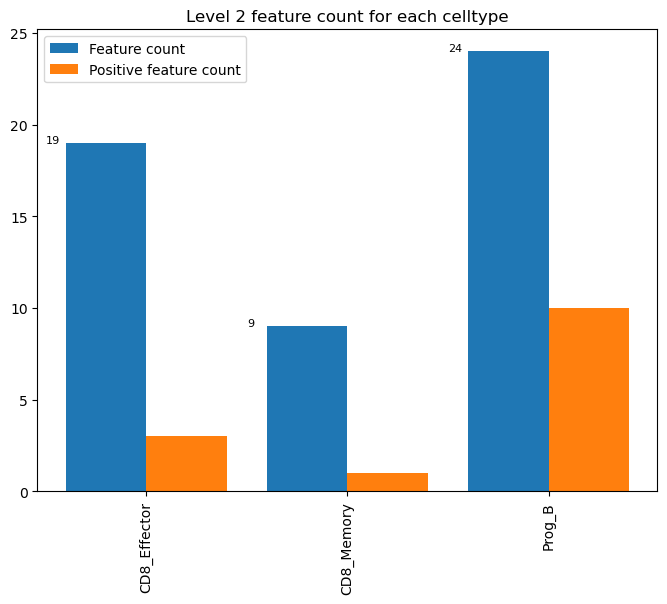

In [26]:
# plot barplot
fig, ax = plt.subplots(figsize=(8, 6))
x = np.arange(len(count_df.index))
bar_width = 0.4

ax.bar(x - bar_width/2, count_df['Feature_count'], bar_width, label='Feature count')
ax.bar(x + bar_width/2, count_df['Positive_feature_count'], bar_width, label='Positive feature count')

# Add the values to each bar
for i, v in enumerate(count_df['Feature_count']):
    plt.text(i-0.5, v, str(v), fontsize=8)
# for i, v in enumerate(count_df['Positive_feature_count']):
#     plt.text(i, v, str(v), fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(count_df.index)
plt.xticks(rotation=90)
plt.title('Level 2 feature count for each celltype')
ax.legend()
# plt.savefig('L2_feature_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Build classifiers (K-fold CV)

In [12]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2.merge'].tolist()]
    print('Unique y:', np.unique(y, return_counts=True))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [14]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_merge')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in cts:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_loss_diff_l2.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: CD8_Effector
Unique y: (array([0, 1]), array([29137,   874]))
[0.9741428574838427, 0.6066692372169609, 0.32496551724137934, 0.422117351429376, 0.9706629685513566, 0.5215288190703465, 0.4317355675440246]
K-fold CV for: CD8_Memory
Unique y: (array([0, 1]), array([29024,   987]))
[0.9666455620351547, 0.2333333333333333, 0.006081115725785777, 0.011756861597153865, 0.9365523344478092, 0.3163611656607159, 0.03129414344096365]
K-fold CV for: Prog_B
Unique y: (array([0, 1]), array([29743,   268]))
[0.9975675496695725, 0.901540289444813, 0.8208944793850455, 0.8581820383720133, 0.9953859643110292, 0.9048013538262598, 0.8584973424861152]


In [15]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD8_Effector,0.974143,0.606669,0.324966,0.422117,0.970663,0.521529,0.431736
CD8_Memory,0.966646,0.233333,0.006081,0.011757,0.936552,0.316361,0.031294
Prog_B,0.997568,0.901540,0.820894,0.858182,0.995386,0.904801,0.858497


In [20]:
# save metrics
# all_metrics.index = types
# all_metrics.to_csv('Metrics_LR_l2.csv')

## Plot alongside unmerged L2 celltype

In [18]:
unmerged_metrics = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_onlylog1p/LR_classifiers/Metrics_LR_l2.csv', index_col=0)
unmerged_metrics.head()

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD14_Mono,0.981807,0.946091,0.970474,0.958124,0.997725,0.990830,0.946633
CD16_Mono,0.998401,0.946051,0.941505,0.943673,0.999051,0.978636,0.942916
CD4_Memory,0.954250,0.833876,0.733546,0.780441,0.971290,0.853270,0.756993
CD4_Naive,0.919530,0.755932,0.660183,0.704695,0.956130,0.781413,0.660470
CD56_bright_NK,0.995835,0.000000,0.000000,0.000000,0.730000,0.012956,0.000000


In [19]:
# List of row labels to append
rows_to_append = ['CD8_Effector_1', 'CD8_Effector_2', 'CD8_Memory_1', 'CD8_Memory_2', 'Prog_B_1', 'Prog_B_2']

# Append the rows to all_metrics
all_metrics = all_metrics.append(unmerged_metrics.loc[rows_to_append])
all_metrics

/var/folders/t1/zclr_f3s57j185f2tblqgwt00000gn/T/ipykernel_3430/2952690295.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_metrics = all_metrics.append(unmerged_metrics.loc[rows_to_append])


,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD8_Effector,0.974143,0.606669,0.324966,0.422117,0.970663,0.521529,0.431736
CD8_Memory,0.966646,0.233333,0.006081,0.011757,0.936552,0.316361,0.031294
Prog_B,0.997568,0.901540,0.820894,0.858182,0.995386,0.904801,0.858497
CD8_Effector_1,0.980707,0.280000,0.019222,0.035860,0.961424,0.295383,0.069261
CD8_Effector_2,0.991237,0.655486,0.294098,0.402595,0.981300,0.522289,0.433277
CD8_Memory_1,0.985339,0.000000,0.000000,0.000000,0.897626,0.117809,-0.000630
CD8_Memory_2,0.981374,0.133333,0.003636,0.007080,0.951147,0.278508,0.019341
Prog_B_1,0.995068,0.200000,0.006897,0.013333,0.837362,0.030611,0.036138
Prog_B_2,0.999167,0.928584,0.873538,0.898490,0.997518,0.944320,0.899367


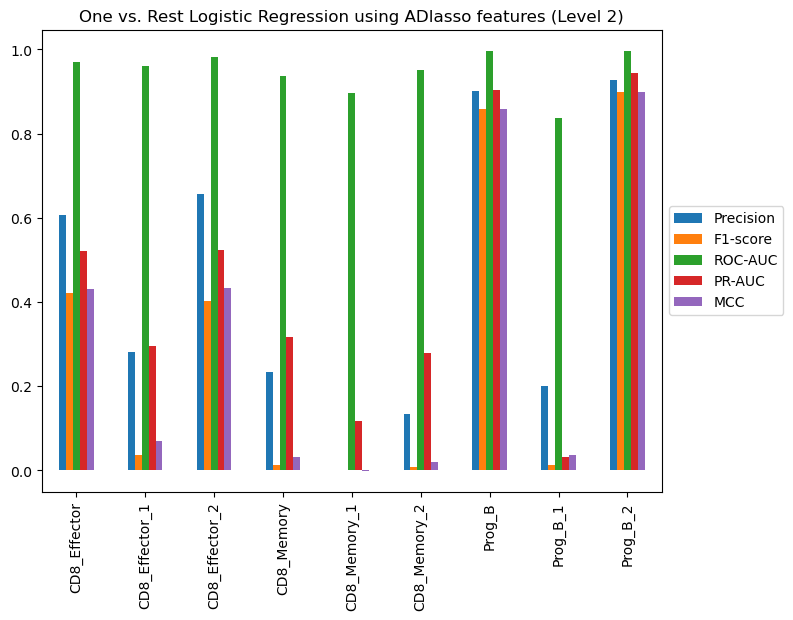

In [22]:
# Sort all_metrics by cell type names
all_metrics_sorted = all_metrics.sort_index()

# Plot metrics for each cell type
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics_sorted[cols].plot.bar(rot=90, figsize=(8, 6), title='One vs. Rest Logistic Regression using ADlasso features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Plot classifier K-fold CV metrics

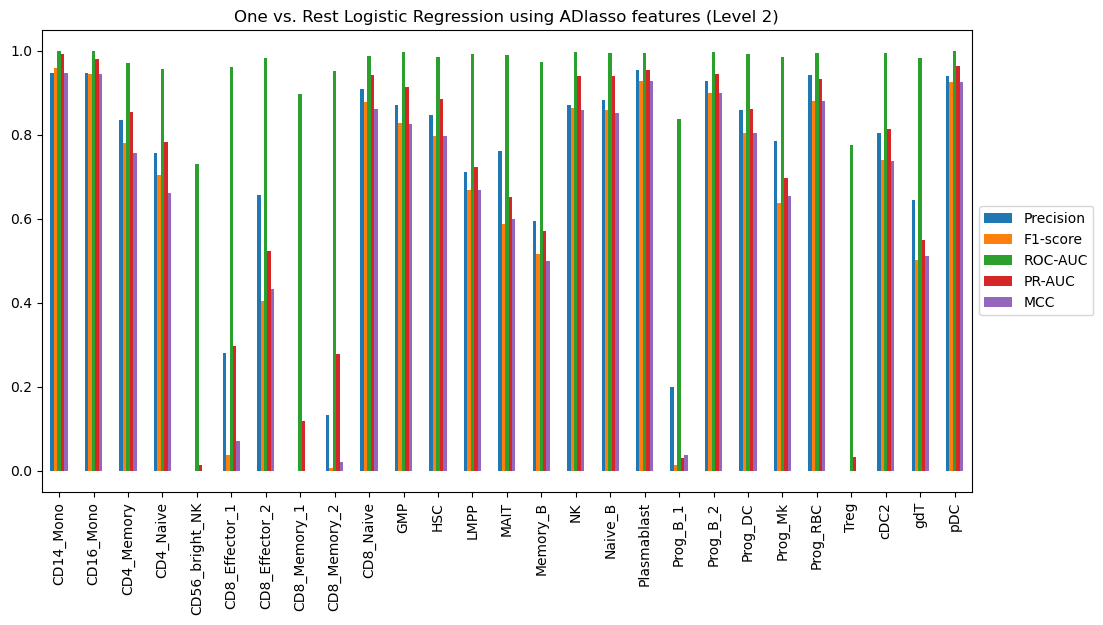

In [24]:
# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(12, 6), title='One vs. Rest Logistic Regression using ADlasso features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


## Evaluate by DEGn

In [25]:
count_df

,Feature_count,Positive_feature_count
CD14_Mono,19,9
CD16_Mono,23,7
CD4_Memory,112,57
CD4_Naive,95,48
CD56_bright_NK,8,0
CD8_Effector_1,14,3
CD8_Effector_2,24,6
CD8_Memory_1,8,1
CD8_Memory_2,10,2
CD8_Naive,170,75


In [26]:
# Read DEG table
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_onlylog1p/L2_DEG/DEG_table')

celltype = 'CD14_Mono'
DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']
DEGn = DEG_table['names'][:n_features].tolist()

In [27]:
n_features

19

In [28]:
DEGn

['FTL',
 'S100A9',
 'TYROBP',
 'LYZ',
 'S100A8',
 'FCN1',
 'S100A6',
 'CTSS',
 'CST3',
 'LST1',
 'S100A4',
 'FTH1',
 'PSAP',
 'VCAN',
 'LGALS1',
 'AIF1',
 'CSTA',
 'GPX1',
 'SRGN']

In [30]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [31]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_onlylog1p/L2_DEG/DEG_table


In [32]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG1000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: CD14_Mono
n: 19
(30011, 19)
Constructing classifier for: CD16_Mono
n: 23
(30011, 23)
Constructing classifier for: CD4_Memory
n: 112
(30011, 112)
Constructing classifier for: CD4_Naive
n: 95
(30011, 95)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: CD56_bright_NK
n: 8
(30011, 8)
Constructing classifier for: CD8_Effector_1
n: 14
(30011, 14)
Constructing classifier for: CD8_Effector_2
n: 24
(30011, 24)
Constructing classifier for: CD8_Memory_1
n: 8
(30011, 8)
Constructing classifier for: CD8_Memory_2
n: 10
(30011, 10)
Constructing classifier for: CD8_Naive
n: 170
(30011, 170)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: GMP
n: 19
(30011, 19)
Constructing classifier for: HSC
n: 27
(30011, 27)
Constructing classifier for: LMPP
n: 15
(30011, 15)
Constructing classifier for: MAIT
n: 5
(30011, 5)
Constructing classifier for: Memory_B
n: 16
(30011, 16)
Constructing classifier for: NK
n: 12
(30011, 12)
Constructing classifier for: Naive_B
n: 23
(30011, 23)
Constructing classifier for: Plasmablast
n: 12
(30011, 12)
Constructing classifier for: Prog_B_1
n: 8
(30011, 8)
Constructing classifier for: Prog_B_2
n: 26
(30011, 26)
Constructing classifier for: Prog_DC
n: 35
(30011, 35)
Constructing classifier for: Prog_Mk
n: 32
(30011, 32)
Constructing classifier for: Prog_RBC
n: 10
(30011, 10)
Constructing classifier for: Treg
n: 9
(30011, 9)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Constructing classifier for: cDC2
n: 24
(30011, 24)
Constructing classifier for: gdT
n: 11
(30011, 11)
Constructing classifier for: pDC
n: 29
(30011, 29)


In [33]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD14_Mono,0.979177,0.928466,0.978244,0.952705,0.996482,0.985790,0.939893
CD16_Mono,0.998334,0.962963,0.917647,0.939759,0.997457,0.968360,0.939195
CD4_Memory,0.941529,0.770154,0.674174,0.718975,0.963914,0.807929,0.688400
CD4_Naive,0.905214,0.711512,0.586957,0.643260,0.940191,0.728591,0.592814
CD56_bright_NK,0.996002,1.000000,0.040000,0.076923,0.979237,0.296463,0.199600
CD8_Effector_1,0.981009,0.500000,0.114035,0.185714,0.969457,0.365802,0.232431
CD8_Effector_2,0.991004,0.589744,0.377049,0.460000,0.980340,0.517885,0.467321
CD8_Memory_1,0.985840,0.666667,0.068182,0.123711,0.946763,0.333038,0.210216
CD8_Memory_2,0.981676,0.500000,0.018182,0.035088,0.959968,0.369749,0.092736
CD8_Naive,0.966350,0.899576,0.829205,0.862958,0.981898,0.924798,0.844724


In [37]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_onlylog1p/L2_DEG')
all_metrics_DEG.to_csv('L2_DEGn_metrics.csv')

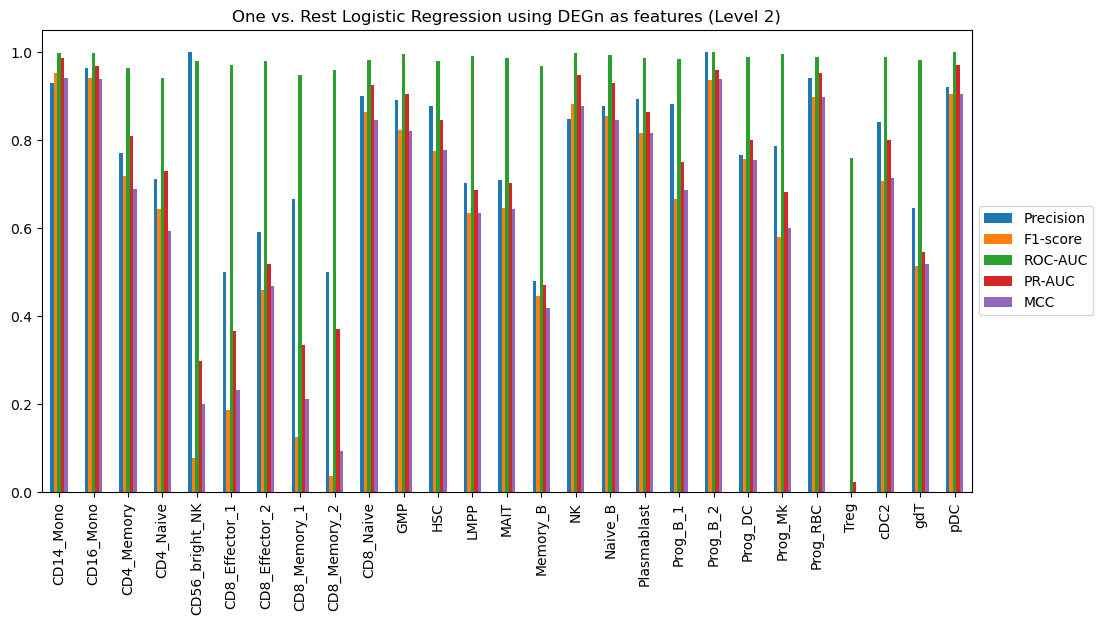

In [38]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=90, figsize=(12,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [39]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD14_Mono,0.981807,0.946091,0.970474,0.958124,0.997725,0.990830,0.946633
CD16_Mono,0.998401,0.946051,0.941505,0.943673,0.999051,0.978636,0.942916
CD4_Memory,0.954250,0.833876,0.733546,0.780441,0.971290,0.853270,0.756993
CD4_Naive,0.919530,0.755932,0.660183,0.704695,0.956130,0.781413,0.660470
CD56_bright_NK,0.995835,0.000000,0.000000,0.000000,0.730000,0.012956,0.000000
CD8_Effector_1,0.980707,0.280000,0.019222,0.035860,0.961424,0.295383,0.069261
CD8_Effector_2,0.991237,0.655486,0.294098,0.402595,0.981300,0.522289,0.433277
CD8_Memory_1,0.985339,0.000000,0.000000,0.000000,0.897626,0.117809,-0.000630
CD8_Memory_2,0.981374,0.133333,0.003636,0.007080,0.951147,0.278508,0.019341
CD8_Naive,0.969911,0.908935,0.849544,0.878128,0.985988,0.941907,0.861698


In [40]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD14_Mono,0.979177,0.928466,0.978244,0.952705,0.996482,0.985790,0.939893
CD16_Mono,0.998334,0.962963,0.917647,0.939759,0.997457,0.968360,0.939195
CD4_Memory,0.941529,0.770154,0.674174,0.718975,0.963914,0.807929,0.688400
CD4_Naive,0.905214,0.711512,0.586957,0.643260,0.940191,0.728591,0.592814
CD56_bright_NK,0.996002,1.000000,0.040000,0.076923,0.979237,0.296463,0.199600
CD8_Effector_1,0.981009,0.500000,0.114035,0.185714,0.969457,0.365802,0.232431
CD8_Effector_2,0.991004,0.589744,0.377049,0.460000,0.980340,0.517885,0.467321
CD8_Memory_1,0.985840,0.666667,0.068182,0.123711,0.946763,0.333038,0.210216
CD8_Memory_2,0.981676,0.500000,0.018182,0.035088,0.959968,0.369749,0.092736
CD8_Naive,0.966350,0.899576,0.829205,0.862958,0.981898,0.924798,0.844724


In [41]:
AD_minus_DEG = all_metrics - all_metrics_DEG
AD_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
CD14_Mono,0.002630,0.017625,-0.007770,0.005419,0.001242,0.005040,0.006740
CD16_Mono,0.000066,-0.016912,0.023858,0.003914,0.001594,0.010276,0.003720
CD4_Memory,0.012721,0.063721,0.059372,0.061466,0.007376,0.045341,0.068593
CD4_Naive,0.014316,0.044420,0.073227,0.061435,0.015939,0.052822,0.067657
CD56_bright_NK,-0.000167,-1.000000,-0.040000,-0.076923,-0.249238,-0.283507,-0.199600
CD8_Effector_1,-0.000302,-0.220000,-0.094813,-0.149854,-0.008033,-0.070419,-0.163170
CD8_Effector_2,0.000232,0.065742,-0.082951,-0.057405,0.000960,0.004404,-0.034044
CD8_Memory_1,-0.000502,-0.666667,-0.068182,-0.123711,-0.049137,-0.215230,-0.210845
CD8_Memory_2,-0.000302,-0.366667,-0.014545,-0.028008,-0.008821,-0.091242,-0.073396
CD8_Naive,0.003561,0.009359,0.020339,0.015170,0.004091,0.017109,0.016974


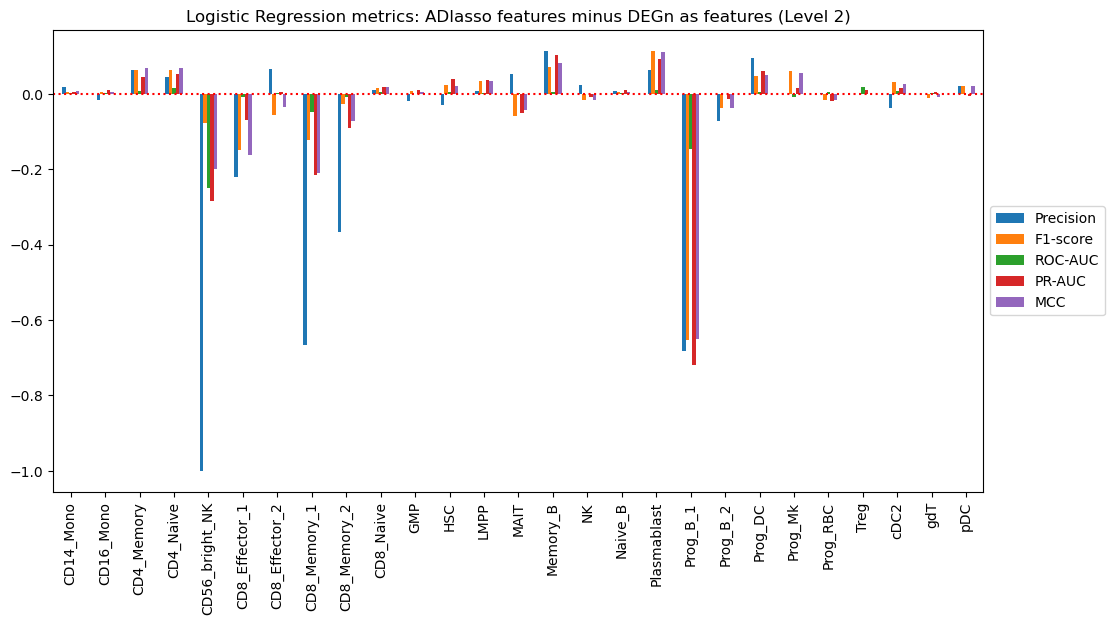

In [45]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = AD_minus_DEG[cols].plot.bar(rot=0, figsize=(12,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features (Level 2)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.xticks(rotation=90)

# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')

